In [ ]:
pip install skfeature-chappers

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, f1_score
from scipy.spatial.distance import mahalanobis
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd

### Upload data

In [ ]:
# Cargar los archivos CSV
labels = pd.read_csv("/content/drive/MyDrive/COLAB RUM/PATTERN RECOGNITION/Final Project /TCGA-PANCAN-HiSeq-801x20531/labels.csv")
data = pd.read_csv("/content/drive/MyDrive/COLAB RUM/PATTERN RECOGNITION/Final Project /TCGA-PANCAN-HiSeq-801x20531/data.csv")

# Combinar ambos datasets en un único DataFrame
merged_data = pd.merge(data, labels, on="sample")

# Verifica el conjunto de datos combinado
print(merged_data.head())
print(merged_data.info())


     sample  gene_0    gene_1    gene_2    gene_3     gene_4  gene_5  \
0  sample_0     0.0  2.017209  3.265527  5.478487  10.431999       0   
1  sample_1     0.0  0.592732  1.588421  7.586157   9.623011       0   
2  sample_2     0.0  3.511759  4.327199  6.881787   9.870730       0   
3  sample_3     0.0  3.663618  4.507649  6.659068  10.196184       0   
4  sample_4     0.0  2.655741  2.821547  6.539454   9.738265       0   

     gene_6    gene_7  gene_8  ...  gene_16374  gene_16375  gene_16376  \
0  7.175175  0.591871     0.0  ...    7.421257    4.692126    1.334282   
1  6.816049  0.000000     0.0  ...    7.991732    5.709045    0.811142   
2  6.972130  0.452595     0.0  ...   10.375778    1.839758    0.000000   
3  7.843375  0.434882     0.0  ...    8.424771    5.502251    0.434882   
4  6.566967  0.360982     0.0  ...   12.176650   10.305423    0.360982   

   gene_16377  gene_16378  gene_16379  gene_16380  gene_16381  gene_16382  \
0    1.650856    3.973382    0.000000    9.29

### Training and testing data splitting

In [ ]:
from sklearn.model_selection import train_test_split

# Separar características (X) y etiquetas (y)
X = merged_data.iloc[:, 1:-1]  # Todas las columnas excepto 'sample' y 'Class'
y = merged_data["Class"]       # Columna de etiquetas

# Training and testing data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (640, 16383), Test set: (161, 16383)


### Characteristics normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Feature extraction and reduction

- Applying Fisher Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Aplicar FDA
lda = LDA(n_components=2)  # Reduce a 2 componentes para visualización (ajusta según sea necesario)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Verificar las dimensiones después de la proyección
print(X_train_lda.shape, X_test_lda.shape)


(640, 2) (161, 2)


- Applying Relief feature selection method

In [ ]:
from skfeature.function.similarity_based import reliefF
import numpy as np

# Aplicar ReliefF
score = reliefF.reliefF(X_train, np.array(y_train))
ranking = np.argsort(score)[::-1]  # Ordenar características por importancia

# Seleccionar las mejores N características (por ejemplo, 50)
selected_features = ranking[:50]
X_train_relief = X_train[:, selected_features]
X_test_relief = X_test[:, selected_features]

print(X_train_relief.shape, X_test_relief.shape)


(640, 50) (161, 50)


## Data Classification

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Función para visualizar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
                annot_kws={"size": 10})
    plt.xlabel('Predicted Labels', fontsize=10)
    plt.ylabel('True Labels', fontsize=10)
    plt.title(title, fontsize=12)
    plt.tight_layout()
    plt.show()

# Función genérica para entrenar, predecir y visualizar resultados
def evaluate_classifier(clf, X_train, y_train, X_test, y_test, method_name, clf_name):
    # Entrenar el clasificador
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Imprimir reporte de clasificación
    print(f"Results with {clf_name} ({method_name}):")
    print(classification_report(y_test, y_pred))

    # Visualizar matriz de confusión
    plot_confusion_matrix(y_test, y_pred, f"Confusion Matrix with {clf_name} ({method_name})")


In [ ]:
# Función para realizar la validación cruzada
def cross_validate_classifier(clf, X, y, method_name, clf_name):
    metrics = ['accuracy', 'f1_macro', 'f1_weighted']

    for metric in metrics:
        scores = cross_val_score(clf, X, y, cv=5, scoring=metric)
        print(f"{clf_name} ({method_name}) - {metric}:")
        print(f"Scores: {scores}")
        print(f"Mean: {scores.mean():.4f}, Std: {scores.std():.4f}\n")

### 1. Mahalanobis distance (Training samples, Testing samples)


In [ ]:
# 1. Clasificador Mahalanobis Distance
class MahalanobisClassifier:
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.cov_inv = np.linalg.inv(np.cov(X.T))

    def predict(self, X_test):
        y_pred = []
        for test_sample in X_test:
            distances = [mahalanobis(test_sample, x, self.cov_inv) for x in self.X_train]
            closest_idx = np.argmin(distances)
            y_pred.append(self.y_train.iloc[closest_idx])
        return y_pred

# Función para adaptar Mahalanobis a cross_val_score
class MahalanobisWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.X_train = None
        self.y_train = None
        self.cov_inv = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.cov_inv = np.linalg.inv(np.cov(X.T))
        return self

    def predict(self, X_test):
        y_pred = []
        for test_sample in X_test:
            distances = [mahalanobis(test_sample, x, self.cov_inv) for x in self.X_train]
            closest_idx = np.argmin(distances)
            y_pred.append(self.y_train.iloc[closest_idx])
        return np.array(y_pred)

    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        return self

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 199, in _get_response_values
    classes = estimator.classes_
AttributeError: 'MahalanobisWrapper' object has no attribute 'classes_'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this trai

Mahalanobis (FDA) - accuracy:
Scores: [nan nan nan nan nan]
Mean: nan, Std: nan

Mahalanobis (FDA) - f1_macro:
Scores: [nan nan nan nan nan]
Mean: nan, Std: nan

Mahalanobis (FDA) - f1_weighted:
Scores: [nan nan nan nan nan]
Mean: nan, Std: nan

Validación Cruzada para Mahalanobis con FDA
Mahalanobis (FDA) - accuracy:
Scores: [nan nan nan nan nan]
Mean: nan, Std: nan



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 199, in _get_response_values
    classes = estimator.classes_
AttributeError: 'MahalanobisWrapper' object has no attribute 'classes_'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this trai

Mahalanobis (FDA) - f1_macro:
Scores: [nan nan nan nan nan]
Mean: nan, Std: nan

Mahalanobis (FDA) - f1_weighted:
Scores: [nan nan nan nan nan]
Mean: nan, Std: nan

------------------------------------------------------------
Validación Cruzada para Mahalanobis con ReliefF
Mahalanobis (ReliefF) - accuracy:
Scores: [nan nan nan nan nan]
Mean: nan, Std: nan

Mahalanobis (ReliefF) - f1_macro:
Scores: [nan nan nan nan nan]
Mean: nan, Std: nan

Mahalanobis (ReliefF) - f1_weighted:
Scores: [nan nan nan nan nan]
Mean: nan, Std: nan

------------------------------------------------------------
Results with Mahalanobis (FDA):
              precision    recall  f1-score   support

        BRCA       1.00      0.97      0.98        61
        COAD       0.89      0.94      0.91        17
        KIRC       1.00      1.00      1.00        25
        LUAD       0.97      1.00      0.98        29
        PRAD       1.00      1.00      1.00        29

    accuracy                           0.98      

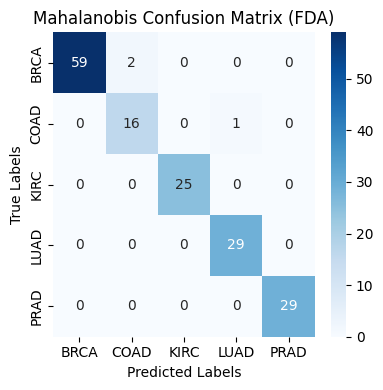

Results with Mahalanobis (ReliefF):
              precision    recall  f1-score   support

        BRCA       0.88      0.82      0.85        61
        COAD       1.00      0.88      0.94        17
        KIRC       0.81      1.00      0.89        25
        LUAD       0.88      0.72      0.79        29
        PRAD       0.76      0.90      0.83        29

    accuracy                           0.85       161
   macro avg       0.86      0.86      0.86       161
weighted avg       0.86      0.85      0.85       161



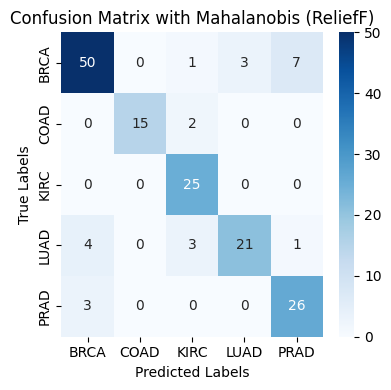

In [ ]:
from scipy.spatial.distance import mahalanobis
import numpy as np

def mahalanobis_classifier(X_train, y_train, X_test):
    cov_matrix = np.linalg.inv(np.cov(X_train.T))
    y_pred = []

    for test_sample in X_test:
        distances = [mahalanobis(test_sample, x, cov_matrix) for x in X_train]
        closest_idx = np.argmin(distances)
        y_pred.append(y_train.iloc[closest_idx])

    return y_pred

# 1. Mahalanobis
mahalanobis_clf = MahalanobisWrapper()
cross_validate_classifier(mahalanobis_clf, X_train_lda, y_train, "FDA", "Mahalanobis")

# Listas de clasificadores y nombres
classifiers = [
    (MahalanobisWrapper(), "Mahalanobis")
]

# Datos: X_train_lda y X_train_relief son los datos transformados por FDA y ReliefF
methods = [("FDA", X_train_lda), ("ReliefF", X_train_relief)]

# Ejecutar validación cruzada para cada clasificador y método
for clf, clf_name in classifiers:
    for method_name, X_train in methods:
        print(f"Validación Cruzada para {clf_name} con {method_name}")
        cross_validate_classifier(clf, X_train, y_train, method_name, clf_name)
        print("-" * 60)

# Evaluar Mahalanobis con FDA
y_pred_lda = mahalanobis_classifier(X_train_lda, y_train, X_test_lda)
print("Results with Mahalanobis (FDA):")
print(classification_report(y_test, y_pred_lda))
plot_confusion_matrix(y_test, y_pred_lda, "Mahalanobis Confusion Matrix (FDA)")

# Evaluar Mahalanobis con ReliefF
y_pred_relief = mahalanobis_classifier(X_train_relief, y_train, X_test_relief)
print("Results with Mahalanobis (ReliefF):")
print(classification_report(y_test, y_pred_relief))
plot_confusion_matrix(y_test, y_pred_relief, "Confusion Matrix with Mahalanobis (ReliefF)")


### 2. KNN (find best K value) (Testing samples)


Validación Cruzada para KNN con FDA
KNN (FDA) - accuracy:
Scores: [0.984375 0.984375 0.96875  0.984375 0.96875 ]
Mean: 0.9781, Std: 0.0077

KNN (FDA) - f1_macro:
Scores: [0.97552448 0.98139642 0.96168671 0.98041433 0.95643234]
Mean: 0.9711, Std: 0.0102

KNN (FDA) - f1_weighted:
Scores: [0.98462085 0.98447856 0.96926312 0.9841995  0.96933524]
Mean: 0.9784, Std: 0.0074

------------------------------------------------------------
Validación Cruzada para KNN con ReliefF
KNN (ReliefF) - accuracy:
Scores: [0.9765625 0.9609375 0.9375    0.90625   0.9296875]
Mean: 0.9422, Std: 0.0245

KNN (ReliefF) - f1_macro:
Scores: [0.97881206 0.96661654 0.94194537 0.90729584 0.92527752]
Mean: 0.9440, Std: 0.0262

KNN (ReliefF) - f1_weighted:
Scores: [0.97672872 0.96099232 0.93690448 0.9043878  0.92957826]
Mean: 0.9417, Std: 0.0251

------------------------------------------------------------
Results with KNN (FDA):
              precision    recall  f1-score   support

        BRCA       1.00      0.95   

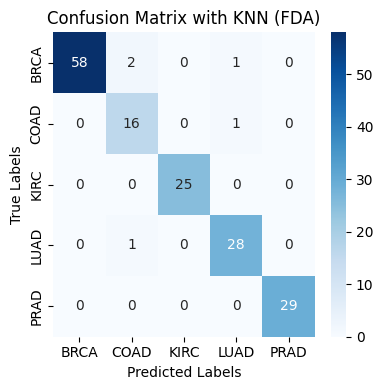

Results with KNN (ReliefF):
              precision    recall  f1-score   support

        BRCA       0.91      0.95      0.93        61
        COAD       1.00      1.00      1.00        17
        KIRC       0.96      0.92      0.94        25
        LUAD       0.96      0.86      0.91        29
        PRAD       0.97      1.00      0.98        29

    accuracy                           0.94       161
   macro avg       0.96      0.95      0.95       161
weighted avg       0.95      0.94      0.94       161



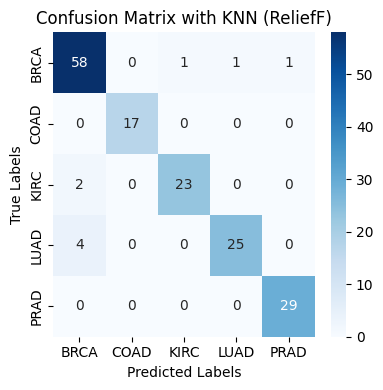

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# 2. Clasificador KNN
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Listas de clasificadores y nombres
classifiers = [
    (knn_clf, "KNN")
]

# Datos: X_train_lda y X_train_relief son los datos transformados por FDA y ReliefF
methods = [("FDA", X_train_lda), ("ReliefF", X_train_relief)]

# Ejecutar validación cruzada para cada clasificador y método
for clf, clf_name in classifiers:
    for method_name, X_train in methods:
        print(f"Validación Cruzada para {clf_name} con {method_name}")
        cross_validate_classifier(clf, X_train, y_train, method_name, clf_name)
        print("-" * 60)

knn = KNeighborsClassifier(n_neighbors=3)
evaluate_classifier(knn, X_train_lda, y_train, X_test_lda, y_test, "FDA", "KNN")
evaluate_classifier(knn, X_train_relief, y_train, X_test_relief, y_test, "ReliefF", "KNN")


### 3. K-means classifier (Testing samples)


Validación Cruzada para K-Means con FDA
K-Means (FDA) - accuracy:
Scores: [0. 0. 0. 0. 0.]
Mean: 0.0000, Std: 0.0000

K-Means (FDA) - f1_macro:
Scores: [nan nan nan nan nan]
Mean: nan, Std: nan

K-Means (FDA) - f1_weighted:
Scores: [nan nan nan nan nan]
Mean: nan, Std: nan

------------------------------------------------------------
Validación Cruzada para K-Means con ReliefF
K-Means (ReliefF) - accuracy:
Scores: [0. 0. 0. 0. 0.]
Mean: 0.0000, Std: 0.0000



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1293, in f1_score
    return fbeta_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 186, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklea

K-Means (ReliefF) - f1_macro:
Scores: [nan nan nan nan nan]
Mean: nan, Std: nan

K-Means (ReliefF) - f1_weighted:
Scores: [nan nan nan nan nan]
Mean: nan, Std: nan

------------------------------------------------------------
Results with K-Means (FDA):
              precision    recall  f1-score   support

        BRCA       1.00      0.93      0.97        61
        COAD       0.77      1.00      0.87        17
        KIRC       1.00      1.00      1.00        25
        LUAD       0.96      0.93      0.95        29
        PRAD       1.00      1.00      1.00        29

    accuracy                           0.96       161
   macro avg       0.95      0.97      0.96       161
weighted avg       0.97      0.96      0.96       161



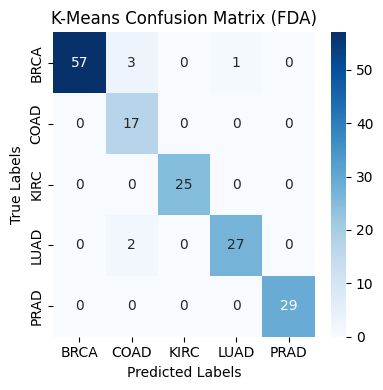

Results with K-Means (ReliefF):
              precision    recall  f1-score   support

        BRCA       0.52      0.98      0.68        61
        COAD       0.76      0.94      0.84        17
        KIRC       0.96      0.96      0.96        25
        LUAD       0.00      0.00      0.00        29
        PRAD       0.00      0.00      0.00        29

    accuracy                           0.62       161
   macro avg       0.45      0.58      0.50       161
weighted avg       0.43      0.62      0.50       161



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


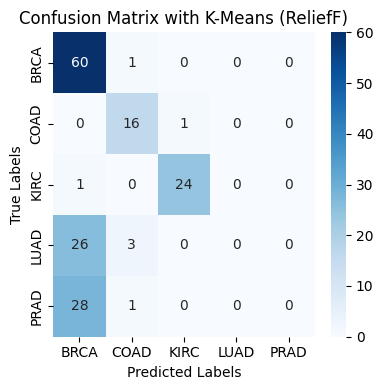

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# 3. Clasificador K-Means
kmeans_clf = KMeans(n_clusters=5, random_state=42)

# Listas de clasificadores y nombres
classifiers = [
    (kmeans_clf, "K-Means")
]

# Datos: X_train_lda y X_train_relief son los datos transformados por FDA y ReliefF
methods = [("FDA", X_train_lda), ("ReliefF", X_train_relief)]

# Ejecutar validación cruzada para cada clasificador y método
for clf, clf_name in classifiers:
    for method_name, X_train in methods:
        print(f"Validación Cruzada para {clf_name} con {method_name}")
        cross_validate_classifier(clf, X_train, y_train, method_name, clf_name)
        print("-" * 60)

# Codificar las etiquetas a valores numéricos
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Función para mapear clusters a etiquetas reales
def map_clusters_to_labels(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        true_labels = y_true[mask]
        unique_labels, counts = np.unique(true_labels, return_counts=True)
        most_common_label = unique_labels[np.argmax(counts)]
        labels[mask] = most_common_label
    return labels

# --- K-Means con FDA ---
kmeans_lda = KMeans(n_clusters=len(np.unique(y_train_encoded)), random_state=42)
y_pred_lda = kmeans_lda.fit_predict(X_test_lda)
y_pred_lda_mapped = map_clusters_to_labels(y_test_encoded, y_pred_lda)
y_pred_lda_mapped = le.inverse_transform(y_pred_lda_mapped)  # Decodificar a etiquetas originales

print("Results with K-Means (FDA):")
print(classification_report(y_test, y_pred_lda_mapped, target_names=le.classes_))
plot_confusion_matrix(y_test, y_pred_lda_mapped, "K-Means Confusion Matrix (FDA)")

# --- K-Means con ReliefF ---
kmeans_relief = KMeans(n_clusters=len(np.unique(y_train_encoded)), random_state=42)
y_pred_relief = kmeans_relief.fit_predict(X_test_relief)
y_pred_relief_mapped = map_clusters_to_labels(y_test_encoded, y_pred_relief)
y_pred_relief_mapped = le.inverse_transform(y_pred_relief_mapped)  # Decodificar a etiquetas originales

print("Results with K-Means (ReliefF):")
print(classification_report(y_test, y_pred_relief_mapped, target_names=le.classes_))
plot_confusion_matrix(y_test, y_pred_relief_mapped, "Confusion Matrix with K-Means (ReliefF)")


### 4. Neural Network - Feedforward NN with Backpropagation (Training samples, Testing samples)


Validación Cruzada para Neural Network con FDA
Neural Network (FDA) - accuracy:
Scores: [0.9921875 0.9765625 0.96875   0.96875   0.984375 ]
Mean: 0.9781, Std: 0.0091

Neural Network (FDA) - f1_macro:
Scores: [0.98755556 0.97236806 0.96168671 0.95366937 0.98082048]
Mean: 0.9712, Std: 0.0123

Neural Network (FDA) - f1_weighted:
Scores: [0.99225694 0.97695431 0.96926312 0.96828076 0.98448868]
Mean: 0.9782, Std: 0.0091

------------------------------------------------------------
Validación Cruzada para Neural Network con ReliefF
Neural Network (ReliefF) - accuracy:
Scores: [0.984375  0.9765625 0.96875   0.984375  0.953125 ]
Mean: 0.9734, Std: 0.0117

Neural Network (ReliefF) - f1_macro:
Scores: [0.98473294 0.97963946 0.97328422 0.98119497 0.94700264]
Mean: 0.9732, Std: 0.0136

Neural Network (ReliefF) - f1_weighted:
Scores: [0.98442472 0.97659247 0.96843781 0.98449383 0.95274029]
Mean: 0.9733, Std: 0.0119

------------------------------------------------------------
Results with Neural Ne

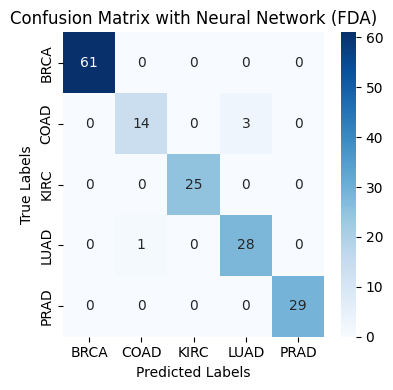

Results with Neural Network (ReliefF):
              precision    recall  f1-score   support

        BRCA       0.95      0.95      0.95        61
        COAD       1.00      1.00      1.00        17
        KIRC       1.00      1.00      1.00        25
        LUAD       0.93      0.90      0.91        29
        PRAD       0.97      1.00      0.98        29

    accuracy                           0.96       161
   macro avg       0.97      0.97      0.97       161
weighted avg       0.96      0.96      0.96       161



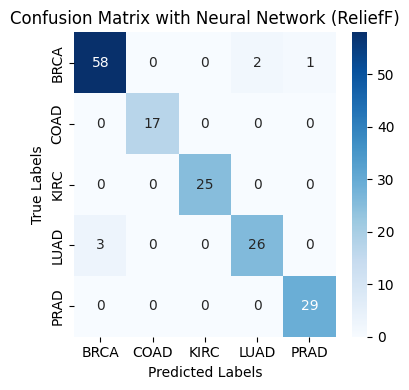

In [ ]:
from sklearn.neural_network import MLPClassifier

# 4. Clasificador Neural Network
nn_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Listas de clasificadores y nombres
classifiers = [
    (nn_clf, "Neural Network")
]

# Datos: X_train_lda y X_train_relief son los datos transformados por FDA y ReliefF
methods = [("FDA", X_train_lda), ("ReliefF", X_train_relief)]

# Ejecutar validación cruzada para cada clasificador y método
for clf, clf_name in classifiers:
    for method_name, X_train in methods:
        print(f"Validación Cruzada para {clf_name} con {method_name}")
        cross_validate_classifier(clf, X_train, y_train, method_name, clf_name)
        print("-" * 60)

nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
evaluate_classifier(nn, X_train_lda, y_train, X_test_lda, y_test, "FDA", "Neural Network")
evaluate_classifier(nn, X_train_relief, y_train, X_test_relief, y_test, "ReliefF", "Neural Network")


### 5. SVM classifier (Testing samples)

Validación Cruzada para SVM con FDA
SVM (FDA) - accuracy:
Scores: [0.9921875 0.9765625 0.96875   0.984375  0.9765625]
Mean: 0.9797, Std: 0.0080

SVM (FDA) - f1_macro:
Scores: [0.98755556 0.97236806 0.96168671 0.97424242 0.9681983 ]
Mean: 0.9728, Std: 0.0085

SVM (FDA) - f1_weighted:
Scores: [0.99225694 0.97695431 0.96926312 0.984375   0.97675518]
Mean: 0.9799, Std: 0.0078

------------------------------------------------------------
Validación Cruzada para SVM con ReliefF
SVM (ReliefF) - accuracy:
Scores: [0.953125  0.9453125 0.9609375 0.953125  0.953125 ]
Mean: 0.9531, Std: 0.0049

SVM (ReliefF) - f1_macro:
Scores: [0.95249623 0.9480806  0.96103252 0.95329481 0.9475865 ]
Mean: 0.9525, Std: 0.0048

SVM (ReliefF) - f1_weighted:
Scores: [0.95319814 0.94539253 0.96053576 0.95278911 0.95291714]
Mean: 0.9530, Std: 0.0048

------------------------------------------------------------
Results with SVM (FDA):
              precision    recall  f1-score   support

        BRCA       1.00      0.

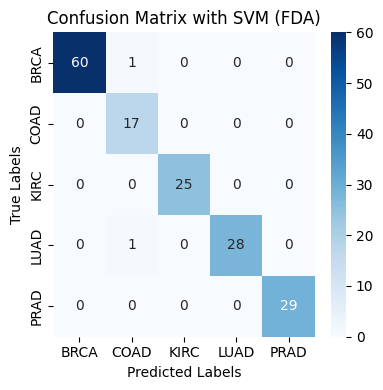

Results with SVM (ReliefF):
              precision    recall  f1-score   support

        BRCA       0.95      0.93      0.94        61
        COAD       1.00      1.00      1.00        17
        KIRC       1.00      1.00      1.00        25
        LUAD       0.90      0.93      0.92        29
        PRAD       0.97      0.97      0.97        29

    accuracy                           0.96       161
   macro avg       0.96      0.97      0.96       161
weighted avg       0.96      0.96      0.96       161



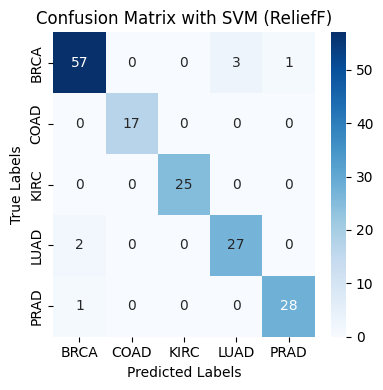

In [ ]:
from sklearn.svm import SVC

# 5. Clasificador SVM
svm_clf = SVC(kernel='linear', random_state=42)

# Listas de clasificadores y nombres
classifiers = [
    (svm_clf, "SVM")
]

# Datos: X_train_lda y X_train_relief son los datos transformados por FDA y ReliefF
methods = [("FDA", X_train_lda), ("ReliefF", X_train_relief)]

# Ejecutar validación cruzada para cada clasificador y método
for clf, clf_name in classifiers:
    for method_name, X_train in methods:
        print(f"Validación Cruzada para {clf_name} con {method_name}")
        cross_validate_classifier(clf, X_train, y_train, method_name, clf_name)
        print("-" * 60)

svm = SVC(kernel='linear', random_state=42)
evaluate_classifier(svm, X_train_lda, y_train, X_test_lda, y_test, "FDA", "SVM")
evaluate_classifier(svm, X_train_relief, y_train, X_test_relief, y_test, "ReliefF", "SVM")


### 6. Random forest classifier (Testing samples)


Validación Cruzada para Random Forest con FDA
Random Forest (FDA) - accuracy:
Scores: [0.96875   0.9765625 0.96875   0.9609375 0.96875  ]
Mean: 0.9688, Std: 0.0049

Random Forest (FDA) - f1_macro:
Scores: [0.95575633 0.96917679 0.96168671 0.94277867 0.95643234]
Mean: 0.9572, Std: 0.0087

Random Forest (FDA) - f1_weighted:
Scores: [0.96854879 0.9767818  0.96926312 0.96075058 0.96933524]
Mean: 0.9689, Std: 0.0051

------------------------------------------------------------
Validación Cruzada para Random Forest con ReliefF
Random Forest (ReliefF) - accuracy:
Scores: [0.9609375 0.9765625 0.96875   0.953125  0.9296875]
Mean: 0.9578, Std: 0.0161

Random Forest (ReliefF) - f1_macro:
Scores: [0.96086721 0.97928823 0.97102622 0.95394489 0.92654645]
Mean: 0.9583, Std: 0.0181

Random Forest (ReliefF) - f1_weighted:
Scores: [0.96059932 0.97643615 0.96865759 0.9529551  0.92995649]
Mean: 0.9577, Std: 0.0159

------------------------------------------------------------
Results with Random Forest (FD

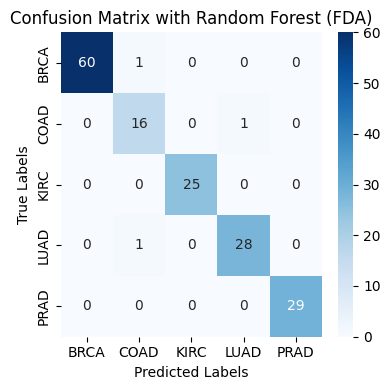

Results with Random Forest (ReliefF):
              precision    recall  f1-score   support

        BRCA       0.95      1.00      0.98        61
        COAD       1.00      1.00      1.00        17
        KIRC       1.00      1.00      1.00        25
        LUAD       1.00      0.90      0.95        29
        PRAD       1.00      1.00      1.00        29

    accuracy                           0.98       161
   macro avg       0.99      0.98      0.98       161
weighted avg       0.98      0.98      0.98       161



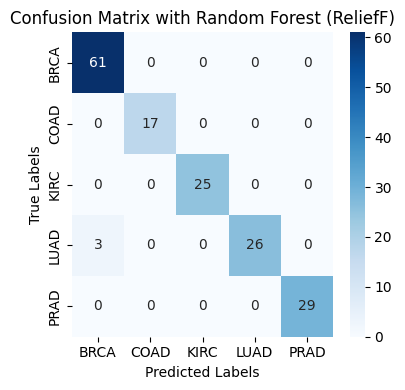

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 6. Clasificador Random Forest
rf_clf = RandomForestClassifier(random_state=42)

# Listas de clasificadores y nombres
classifiers = [
    (rf_clf, "Random Forest")
]

# Datos: X_train_lda y X_train_relief son los datos transformados por FDA y ReliefF
methods = [("FDA", X_train_lda), ("ReliefF", X_train_relief)]

# Ejecutar validación cruzada para cada clasificador y método
for clf, clf_name in classifiers:
    for method_name, X_train in methods:
        print(f"Validación Cruzada para {clf_name} con {method_name}")
        cross_validate_classifier(clf, X_train, y_train, method_name, clf_name)
        print("-" * 60)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_classifier(rf, X_train_lda, y_train, X_test_lda, y_test, "FDA", "Random Forest")
evaluate_classifier(rf, X_train_relief, y_train, X_test_relief, y_test, "ReliefF", "Random Forest")
